In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
class SimpsonsDataset(Dataset):
    def __init__(self, files_path, data_transforms):
        super().__init__()
        self.files_path = files_path
        self.transform = data_transforms
        if 'test' not in str(self.files_path[0]):
            self.labels = [path.parent.name for path in self.files_path]
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, idx):
        img_path = str(self.files_path[idx])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        if 'test' in str(self.files_path[0]):
            return image
        else:
            label_str = str(self.files_path[idx].parent.name)
            label = self.label_encoder.transform([label_str]).item()
            return image, label

In [3]:
import kaggle
from zipfile import ZipFile

kaggle.api.authenticate()
kaggle.api.dataset_download_files("alexattia/the-simpsons-characters-dataset")
with ZipFile("/content/the-simpsons-characters-dataset.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content/the-simpsons-characters-dataset/")

In [4]:
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson', 12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
train_dir = Path('/content/the-simpsons-characters-dataset/simpsons_dataset/')
test_dir = Path('/content/the-simpsons-characters-dataset/kaggle_simpson_testset/')
train_val_files_path = sorted(list(train_dir.rglob('*.jpg')))
test_path = sorted(list(test_dir.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files_path]
train_files_path, val_files_path = train_test_split(train_val_files_path, test_size = 0.3, stratify=train_val_labels)

in_size = 32
num_classes = len(np.unique(train_val_labels))

In [5]:
train_dataset = SimpsonsDataset(train_files_path, transforms.Compose([transforms.Resize((in_size, in_size)), transforms.ToTensor()]))
val_dataset = SimpsonsDataset(val_files_path, transforms.Compose([transforms.Resize((in_size, in_size)), transforms.ToTensor()]))
test_dataset = SimpsonsDataset(test_path, transforms.Compose([transforms.Resize((in_size, in_size)), transforms.ToTensor()]))

In [6]:
batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
def imshow(inp, title, ax):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.set_title(title)
    ax.grid(False)

Number of train samples: 29306
Number of test samples: 990


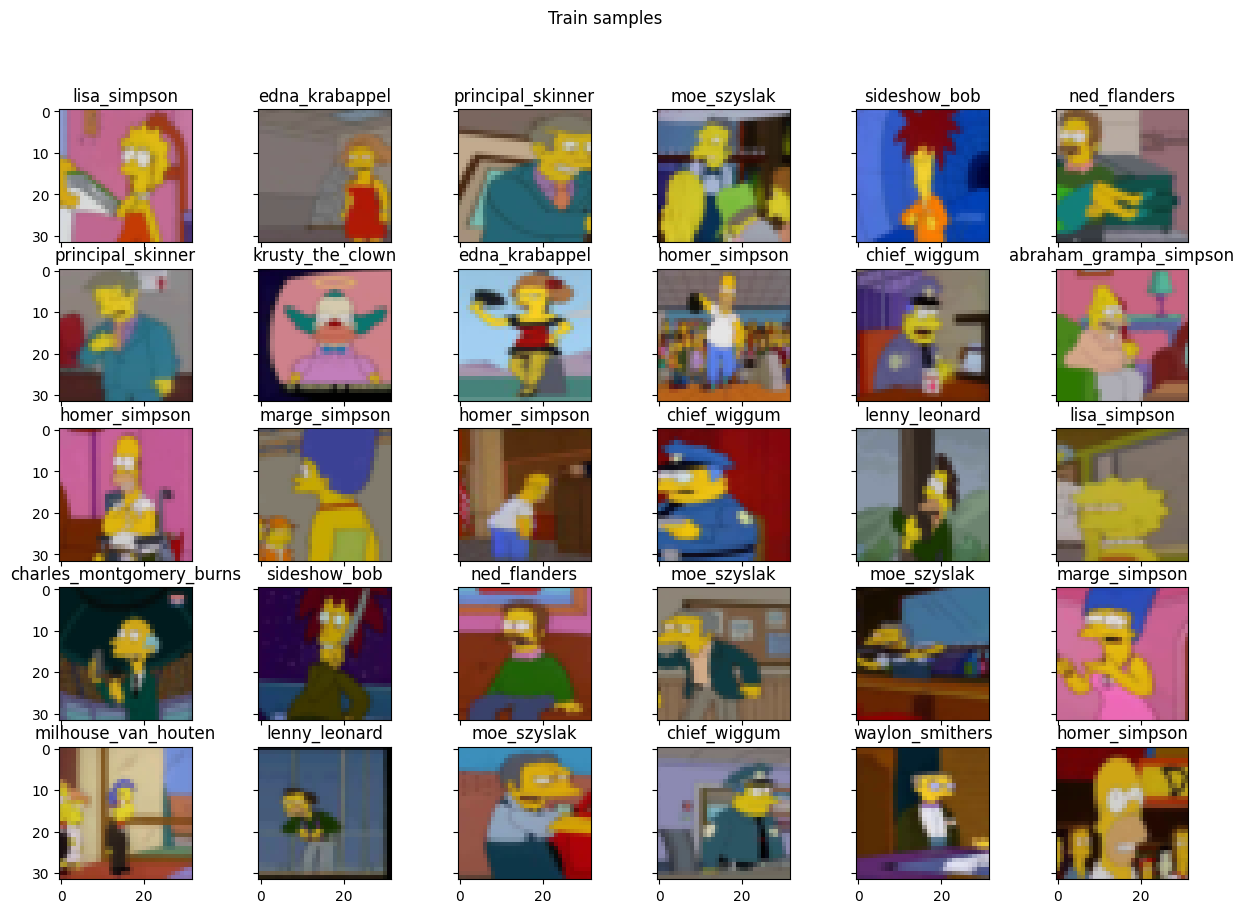

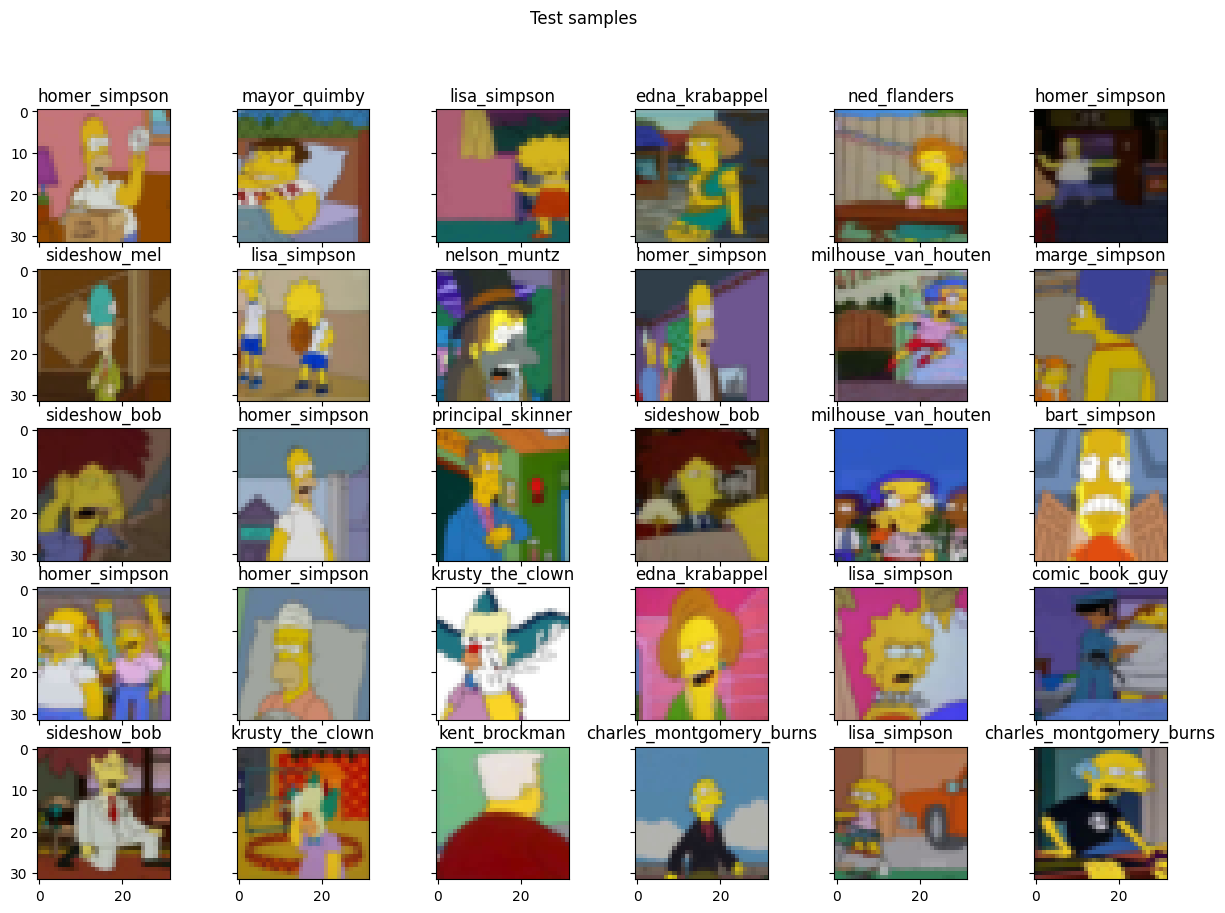

In [43]:
print('Number of train samples: {}'.format(len(train_dataset)))
fig, ax = plt.subplots(
    nrows=5,
    ncols=6,
    figsize=(15, 10),
    sharex=True,
    sharey=True,
)
fig.suptitle('Train samples')
for fig_x in ax.flatten():
    random_character = np.random.randint(0, len(train_dataset))
    im_val, label = train_dataset[random_character]
    img_label = train_dataset.label_encoder.inverse_transform([label]).item()
    imshow(im_val.data.cpu(), img_label, fig_x)

print('Number of test samples: {}'.format(len(test_dataset)))
fig, ax = plt.subplots(
    nrows=5,
    ncols=6,
    figsize=(15, 10),
    sharex=True,
    sharey=True,
)
fig.suptitle('Test samples')
for fig_x in ax.flatten():
    random_character = np.random.randint(0, len(test_dataset))
    im_val, label = train_dataset[random_character]
    img_label = train_dataset.label_encoder.inverse_transform([label]).item()
    imshow(im_val.data.cpu(), img_label, fig_x)

In [20]:
import sklearn

def get_f1_score(model, data_loader, device):
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return sklearn.metrics.f1_score(true_labels, predicted_labels, average='weighted')

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(sklearn.metrics.f1_score(labels.cpu(), predicted.cpu(), average='weighted'))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 20
learning_rate=0.001

In [9]:
def train_loop(model, train_dataloader, optimizer, loss_function):
  start_all = time.time()
  for epoch in range(num_epochs):
      start = time.time()
      accuracis = []
      for images, labels in train_dataloader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = loss_function(outputs, labels)
          acc = accuracy(outputs, labels)
          accuracis.append(acc)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      end = time.time()
      print('Epoch[{}]: accuracy = {}, time = {}'.format(epoch, torch.stack(accuracis).mean(), (end - start)))
  end_all = time.time()
  print('train time = {}'.format((end_all - start_all)))

In [10]:
class ConvBlock(torch.nn.Sequential):
    """
    Standard convolution block with Batch normalization and activation.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 ksize,
                 stride,
                 padding,
                 groups=1,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=torch.nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.activate = (activation is not None)
        self.use_bn = use_bn

        self.conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=ksize,
            stride=stride,
            padding=padding,
            groups=groups)
        if self.use_bn:
            self.bn = torch.nn.BatchNorm2d(out_channels, eps=bn_eps)
        if self.activate:
            self.activ = activation

    def __call__(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x

In [11]:
def conv1x1_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=0,
                  groups=1,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=torch.nn.ReLU()):

    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        ksize=1,
        stride=stride,
        padding=padding,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)

In [12]:
def conv3x3_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=1,
                  groups=1,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=torch.nn.ReLU()):

    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        ksize=3,
        stride=stride,
        padding=padding,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)

In [13]:
class MyResNet(torch.nn.Module):
    def __init__(self):
        super(MyResNet, self).__init__()
        self.conv1 = conv3x3_block(
                    in_channels=3,
                    out_channels=64,
                    activation=torch.nn.ReLU(inplace=True))
        self.conv_maxpool_1 = torch.nn.Sequential(
            conv3x3_block(
                in_channels=64,
                out_channels=128,
                activation=torch.nn.ReLU(inplace=True)),
            torch.nn.MaxPool2d(kernel_size=2))
        self.residue1 = torch.nn.Sequential(
            conv3x3_block(
                in_channels=128,
                out_channels=128,
                activation=torch.nn.ReLU(inplace=True)),
            conv3x3_block(
                in_channels=128,
                out_channels=128,
                activation=torch.nn.ReLU(inplace=True)))

        self.conv_maxpool_2 = torch.nn.Sequential(
            conv3x3_block(
                in_channels=128,
                out_channels=256,
                activation=torch.nn.ReLU(inplace=True)),
            torch.nn.MaxPool2d(kernel_size=2))
        self.conv_maxpool_3 = torch.nn.Sequential(
            conv3x3_block(
                in_channels=256,
                out_channels=512,
                activation=torch.nn.ReLU(inplace=True)),
             torch.nn.MaxPool2d(kernel_size=2))
        self.residue2 = torch.nn.Sequential(
            conv3x3_block(
                in_channels=512,
                out_channels=512,
                activation=torch.nn.ReLU(inplace=True)),
            conv3x3_block(
                in_channels=512,
                out_channels=512,
                activation=torch.nn.ReLU(inplace=True)))

        self.final_pooling = torch.nn.MaxPool2d(kernel_size=4)
        self.dense = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Dropout(0.2), torch.nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv_maxpool_1(out)
        out = self.residue1(out) + out
        out = self.conv_maxpool_2(out)
        out = self.conv_maxpool_3(out)
        out = self.residue2(out) + out
        out = self.final_pooling(out)
        out = self.dense(out)
        return out

In [14]:
model = MyResNet()
model

MyResNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): ReLU(inplace=True)
  )
  (conv_maxpool_1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residue1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum

In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.to(device)

MyResNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): ReLU(inplace=True)
  )
  (conv_maxpool_1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residue1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum

In [16]:
train_loop(model, train_dataloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.5949216457435295, time = 87.54866147041321
Epoch[1]: accuracy = 0.8379828893898081, time = 83.26993203163147
Epoch[2]: accuracy = 0.9063292631905729, time = 82.47957372665405
Epoch[3]: accuracy = 0.9392090124799619, time = 81.91137957572937
Epoch[4]: accuracy = 0.9616168150446655, time = 84.03104424476624
Epoch[5]: accuracy = 0.9733466190352659, time = 82.04602336883545
Epoch[6]: accuracy = 0.975546464671531, time = 81.72818994522095
Epoch[7]: accuracy = 0.9812574530366616, time = 84.92157411575317
Epoch[8]: accuracy = 0.9839694153500793, time = 82.16596555709839
Epoch[9]: accuracy = 0.9840913923620282, time = 82.57307505607605
Epoch[10]: accuracy = 0.9870629977506722, time = 85.23914527893066
Epoch[11]: accuracy = 0.9858663611851699, time = 82.63614320755005
Epoch[12]: accuracy = 0.9886536917180713, time = 82.30145478248596
Epoch[13]: accuracy = 0.9901469473262295, time = 83.92805123329163
Epoch[14]: accuracy = 0.9863913380324211, time = 81.12562227249146
Epoch[

In [21]:
print('Acc = {}'.format(get_f1_score(model, val_dataloader, device)))

Acc = 0.9789765491711299


In [22]:
@torch.no_grad()
def predict(data_loader, model, device):
    model.eval()
    prediction = []
    for images in data_loader:
        images = images.to(device)
        outputs = model(images)
        _, labels = torch.max(outputs.data, 1)
        prediction.append(labels.cpu())
    return torch.cat(prediction).numpy()

In [23]:
labels = predict(test_dataloader, model, device)

In [24]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [25]:
decoded_labels = label_encoder.inverse_transform(labels)

In [26]:
test_filenames = ['_'.join(path.name.split('_')[:-1]) for path in test_dataset.files_path]

In [27]:
print('Acc = {}'.format(sklearn.metrics.f1_score(test_filenames, decoded_labels, average="weighted")))

Acc = 0.9949384627816035
